In [29]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

In [30]:
# set directories and files

datadir=r"C:\\Users\\dswanson\\Documents\\Files\\Satellites\\LLITED\\06 data\\"
ephdir=datadir+r'ephemeris\\Ephemeris_simple\\'
savedir=r"C:\\Users\\dswanson\\Documents\\Files\\Satellites\\LLITED\\05 analysis\\gannon day storm\\plots\\"

pipdatadir = datadir+'\\PIP\\L2\\'
migsidatadir = datadir+'\\MIGSI\\L2\\'
pipfiles=[pipdatadir+'LLITED_B_PIP_20240507_L2_v4.nc4',\
pipdatadir+'LLITED_B_PIP_20240511_L2_v4.nc4',\
pipdatadir+'LLITED_B_PIP_20240513_L2_v4.nc4']

migsifiles=[migsidatadir+'LLITEDB_MIGSI_20240507_033038_L2_v01.nc',\
            migsidatadir+'LLITEDB_MIGSI_20240511_050238_L2_v01.nc',\
            migsidatadir+'LLITEDB_MIGSI_20240513_050138_L2_v01.nc']


In [31]:
# calculate averages for LLITED data to compare to TIE-GCM Profiles

may_nden = [None]*len(migsifiles)
may_alt = [None]*len(migsifiles)
may_ni = [None]*len(migsifiles)

# focus only on SH May 7,11,13 files
for j in range(3) :
    pipfile=pipfiles[j]
    migsifile=migsifiles[j]
    date1 = pipfile.split('_')[3]
    print(date1)
    
    #Load the NetCDF files into a new xarray dataset
    pip = xr.open_dataset(pipfile)
    pip_s1970=pip['time'].values.astype('int64')*1e-9
   
    migsi = xr.open_dataset(migsifile)
    
    eph = xr.open_dataset(ephdir+'LLITEDB_202405.nc')
    eph_time=eph['UNIX_EPOCH'].astype('datetime64[s]')
        
    # base everything on MIGSI start and end times
    w = np.where((eph['UNIX_EPOCH'] > migsi['s1970'][0]) & (eph['UNIX_EPOCH']< migsi['s1970'][-1] ) )
    wp = np.where((pip_s1970 > migsi['s1970'][0].values) & (pip_s1970< migsi['s1970'][-1].values ) )
    
    # Now that everything has the same start and stop times interpolate data to all be on ephemeris time resolution
    pip_ni=np.interp(eph['UNIX_EPOCH'][w],pip_s1970[wp],pip['Ni'][wp])
    migsi_nden=np.interp(eph['UNIX_EPOCH'][w],migsi['s1970'],migsi['nden'])
    w1= np.where(migsi['nden'] >-1)
    migsi_nden=np.interp(eph['UNIX_EPOCH'][w],migsi['s1970'][w1],migsi['nden'][w1])

    # constain data to region near -61 deg LAT to compare to TIE-GCM profiles at this location
    ww= np.where((eph['LAT (deg)'][w].values < -60.8) & (eph['LAT (deg)'][w].values >-61.2) & (eph['LON (deg)'][w].values >85) & (eph['LON (deg)'][w].values <120) )[0]
    wep= np.where((eph['LAT (deg)'][wp].values < -60.8) & (eph['LAT (deg)'][wp].values >-61.2) & (eph['LON (deg)'][wp].values >85)& (eph['LON (deg)'][wp].values < 120) )[0]

    # take the value at the middle nearest -61 deg 
    may_nden[j] = (migsi['nden'][w1][ww][len(ww)//2].values)
    may_ni[j] = (pip_ni)[ww][len(ww)//2]
    may_alt[j] = (migsi['alt'][w1][ww][len(ww)//2].values)
    #print(' ALT ', may_alt[j])
    #print(' PIP ni ', may_ni[j])
    #print(' MIGSI nden ', may_nden[j])
    #print(' LAT ',(eph['LAT (deg)'][wep][len(wep)//2].values))
    #print(' LON ',(eph['LON (deg)'][wep][len(wep)//2].values))


20240507
20240511
20240513


In [32]:
tiedir='C:\\Users\\dswanson\Documents\\Files\\Satellites\\LLITED\\06 data\\TIEGCM\\May_2024_Storm\\'

file1='TIE_GCM_may7_0340_heelis_fanjiang_height.txt'
file2='TIE_GCM_may11_heelis_fanjiang_height.txt'
file3='TIE_GCM_may13_0520_heelis_fanjiang_height.txt'
file6='TIE_GCM_may07_0520_heelis_fanjiang_height.txt'

head_height=['Lon', 'Lat','H','T_n','Vn_Lon','Vn_Lat','WN','rho(O2)','rho(O)','N2','rho(NO)','rho(N4S)','HE','N_e','T_e','T_i','TEC','N(O2+)',\
      'N(O+)','PHI','Vi_Lon','Vi_Lat','Vi_IP','DEN', 'QJOULE','HMF2', 'NMF2','Z','ZG','SIGMA_PED','SIGMA_HAL','NO_COOL','QJOULE_INTEG',\
      'O_N2','T_lbc','Vlbc_Lon','Vlbc_Lat','TN_lbc','VN_lbc_Lon','VN_lbc_Lat']

tieh1 = pd.read_csv(tiedir+file1, encoding='ascii',names=head_height,sep='\s+',comment='#')
tieh2 = pd.read_csv(tiedir+file2, encoding='ascii',names=head_height,sep='\s+',comment='#')
tieh3 = pd.read_csv(tiedir+file3, encoding='ascii',names=head_height,sep='\s+',comment='#')
tieh6 = pd.read_csv(tiedir+file6, encoding='ascii',names=head_height,sep='\s+',comment='#')


#display(tieh1)

In [33]:
# index where TIE-GCM profiles are between 61-62 LAT
# These files are already constrained to 90 LON

w1=np.where((tieh1['Lat'] <-61) & (tieh1['Lat'] >-62))[0]# 
w2=np.where((tieh2['Lat'] <-61) & (tieh2['Lat'] >-62))[0]# 
w3=np.where((tieh3['Lat'] <-61) & (tieh3['Lat'] >-62))[0]# 
w6=np.where((tieh6['Lat'] <-61) & (tieh6['Lat'] >-62))[0]# 


In [34]:
# Calculate Neutral Number Density from TIE-GCM
na=6.022e23
mm=1/((tieh1['rho(O2)'][w1]/31.999)+(tieh1['rho(O)'][w1]/15.999)+(tieh1['N2'][w1]/28.0134)+(tieh1['rho(NO)'][w1]/30.01)+(tieh1['rho(N4S)'][w1]/88.0918)+(tieh1['HE'][w1]/4.0026)) # ; amu g/mol
mm_kg = mm / (na*1e3)
tiegcm_n1 = tieh1['DEN'][w1]/mm_kg *1e-6 #; convert den to cm^-3 instead of m^-3

mm2=1/((tieh2['rho(O2)'][w2]/31.999)+(tieh2['rho(O)'][w2]/15.999)+(tieh2['N2'][w2]/28.0134)+(tieh2['rho(NO)'][w2]/30.01)+(tieh2['rho(N4S)'][w2]/88.0918)+(tieh2['HE'][w2]/4.0026)) # ; amu g/mol
mm_kg2 = mm2 / (na*1e3)
tiegcm_n2 = tieh2['DEN'][w2]/mm_kg2 *1e-6 #; convert den to cm^-3 instead of m^-3

mm3=1/((tieh3['rho(O2)'][w3]/31.999)+(tieh3['rho(O)'][w3]/15.999)+(tieh3['N2'][w3]/28.0134)+(tieh3['rho(NO)'][w3]/30.01)+(tieh3['rho(N4S)'][w3]/88.0918)+(tieh3['HE'][w3]/4.0026)) # ; amu g/mol
mm_kg3 = mm3 / (na*1e3)
tiegcm_n3 = tieh3['DEN'][w3]/mm_kg3 *1e-6 #; convert den to cm^-3 instead of m^-3

mm6=1/((tieh6['rho(O2)'][w6]/31.999)+(tieh6['rho(O)'][w6]/15.999)+(tieh6['N2'][w6]/28.0134)+(tieh6['rho(NO)'][w6]/30.01)+(tieh6['rho(N4S)'][w6]/88.0918)+(tieh6['HE'][w6]/4.0026)) # ; amu g/mol
mm_kg6 = mm6 / (na*1e3)
tiegcm_n6 = tieh6['DEN'][w6]/mm_kg6*1e-6 #; convert den to cm^-3 instead of m^-3


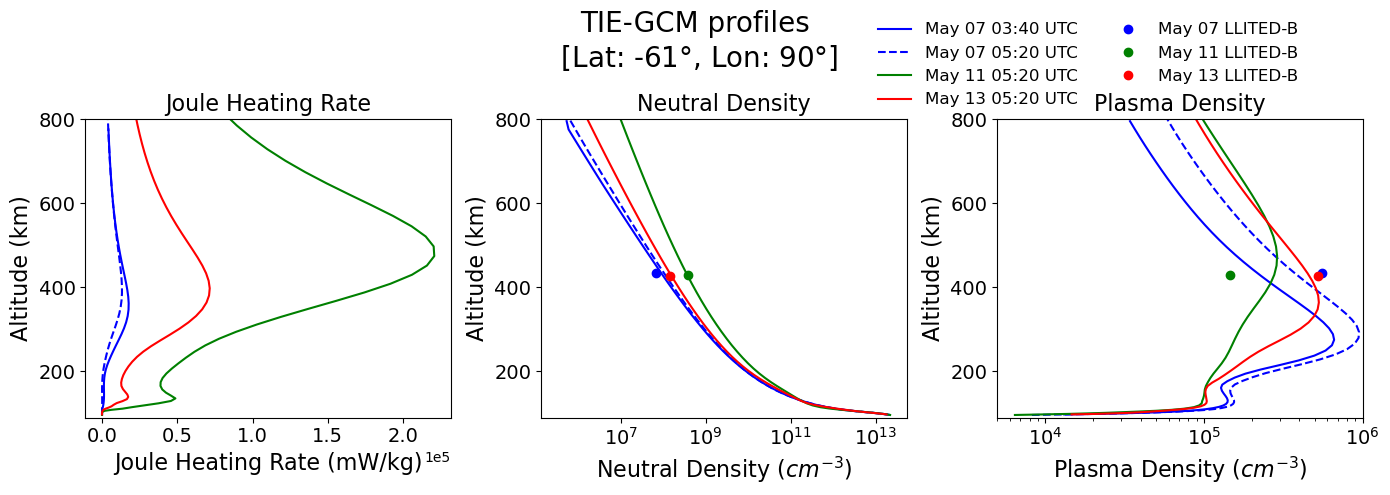

In [35]:
# Plot combo plot of Joule Heating, Neutral Density and Plasma Density. 
# TIE-GCM proiles with LLITED measurements overplot

fig, axs = plt.subplots(1, 3, figsize=(14,5)) 

fig.suptitle('TIE-GCM profiles\n [Lat: -61$\degree$, Lon: 90$\degree$]',fontsize=20)
axs[0].plot(tieh1['QJOULE'][w1],tieh1['H'][w1],'b', label='May 07 03:40 UTC')# Integ: '+str(tieh1['QJOULE_INTEG'][1000])[0:4]+'mW/kg')
axs[0].plot(tieh6['QJOULE'][w6],tieh6['H'][w6], '--b',label='May 07 05:20 UTC')# Integ: '+str(tieh6['QJOULE_INTEG'][1000])[0:4]+'mW/kg')

axs[0].plot(tieh2['QJOULE'][w2],tieh2['H'][w2], 'g',label='May 11 05:20 UTC')# Integ: '+str(tieh2['QJOULE_INTEG'][1000])[0:4]+'mW/kg')
axs[0].plot(tieh3['QJOULE'][w3],tieh3['H'][w3], 'r',label='May 13 05:20 UTC')# Integ: '+str(tieh3['QJOULE_INTEG'][1000])[0:4]+'mW/kg')

axs[0].set_ylabel('Altitude (km)',fontsize=16)
axs[0].set_xlabel('Joule Heating Rate (mW/kg)',fontsize=16)
axs[0].set_ylim([90,800])
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].set_title('Joule Heating Rate',fontsize=16)


axs[1].plot(tiegcm_n1,tieh1['H'][w1],'b', label='May 07 03:40 UTC')
axs[1].plot(tiegcm_n6,tieh6['H'][w6],'--b', label='May 07 05:20 UTC')
axs[1].plot(tiegcm_n2,tieh2['H'][w2],'g', label='May 11 05:20 UTC')
axs[1].plot(tiegcm_n3,tieh3['H'][w3],'r', label='May 13 05:20 UTC')

axs[1].plot(may_nden[0],may_alt[0],'ob',label='May 07 LLITED-B')
axs[1].plot(may_nden[1],may_alt[1],'og',label='May 11 LLITED-B')
axs[1].plot(may_nden[2],may_alt[2],'or',label='May 13 LLITED-B')

axs[1].set_ylabel('Altitude (km)',fontsize=16)
axs[1].set_xlabel('Neutral Density $(cm^{-3})$',fontsize=16)
axs[1].set_ylim([90,800])
axs[1].set_xscale('log')
axs[1].set_title('Neutral Density',fontsize=16)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

axs[2].plot(tieh1['N_e'][w1],tieh1['H'][w1], 'b')#,label='HmF2 286 km')#'+str(tieh1['HMF2'][w1])[0:3]+' km')
axs[2].plot(tieh6['N_e'][w6],tieh6['H'][w6], '--b')#,label='HmF2 295 km')#'+str(tieh6['HMF2'][w6])[0:3]+' km')

axs[2].plot(tieh2['N_e'][w2],tieh2['H'][w2], 'g')#,label='HmF2 493 km')#'+str(tieh2['HMF2'][w2])[0:3]+' km')
axs[2].plot(tieh3['N_e'][w3],tieh3['H'][w3],'r')#, label='HmF2 379 km')#'+str(tieh3['HMF2'][w3])[0:3]+' km')

axs[2].plot(may_ni[0]/1e6,may_alt[0],'ob',label='May 07 LLITED-B')
axs[2].plot(may_ni[1]/1e6,may_alt[1],'og',label='May 11 LLITED-B')
axs[2].plot(may_ni[2]/1e6,may_alt[2],'or',label='May 13 LLITED-B')

axs[2].set_ylabel('Altitude (km)',fontsize=16)
axs[2].set_xlabel('Plasma Density ($cm^{-3}$)',fontsize=16)
axs[2].set_ylim([90,800])
axs[2].set_xlim([5e3,1e6])

axs[2].set_xscale('log')
axs[2].set_title('Plasma Density',fontsize=16)
axs[2].tick_params(axis='x', labelsize=14)
axs[2].tick_params(axis='y', labelsize=14)


handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles,labels,loc='upper left',bbox_to_anchor=(0.62, 0.985), fontsize=12,frameon=False,ncol=2)    # optional: makes it more compact


plt.tight_layout()

#plt.savefig(savedir+'TIEGCM\\LLITED_TIEGCM_vertical_profiles.png',facecolor='white',transparent=0,bbox_inches='tight')


In [36]:
# Include IRI profiles

irifilemay7=r'C:\Users\dswanson\Documents\Files\Satellites\LLITED\06 data\IRI\iri2020_may07_profile.txt'
irifilemay11=r'C:\Users\dswanson\Documents\Files\Satellites\LLITED\06 data\IRI\iri2020_may11_profile.txt'
irifilemay13=r'C:\Users\dswanson\Documents\Files\Satellites\LLITED\06 data\IRI\iri2020_may13_profile.txt'

irimay7 = pd.read_csv(irifilemay7, encoding='ascii',header=28,sep='\s+',comment='#')
irimay11 = pd.read_csv(irifilemay11, encoding='ascii',header=28,sep='\s+',comment='#')
irimay13 = pd.read_csv(irifilemay13, encoding='ascii',header=28,sep='\s+',comment='#')

al1=np.where((irimay7['km']>tieh1['H'][w1[0]]) & ((irimay7['km']<tieh1['H'][w1[-1]])))[0]
al2=np.where((irimay11['km']>tieh2['H'][w2[0]]) & ((irimay11['km']<tieh2['H'][w2[-1]])))[0]
al3=np.where((irimay13['km']>tieh3['H'][w3[0]]) & ((irimay13['km']<tieh3['H'][w3[-1]])))[0]

# interpolate to same array as tiegcm

irimay11Ne=np.interp(tieh1['H'][w1],irimay11['km'][al1],irimay11['Ne/cm-3'][al1])*1e6
irimay07Ne=np.interp(tieh2['H'][w2],irimay7['km'][al2],irimay7['Ne/cm-3'][al2])*1e6
irimay13Ne=np.interp(tieh3['H'][w3],irimay13['km'][al3],irimay13['Ne/cm-3'][al3])*1e6

# interpolate to same array as tiegcm
irimay11NOp=np.interp(tieh1['H'][w1],irimay11['km'][al1],irimay11['NO+'][al1])*irimay11Ne
irimay07NOp=np.interp(tieh2['H'][w2],irimay7['km'][al2],irimay7['NO+'][al2])*irimay07Ne
irimay13NOp=np.interp(tieh3['H'][w3],irimay13['km'][al3],irimay13['NO+'][al3])*irimay13Ne

irimay11Op=np.interp(tieh1['H'][w1],irimay11['km'][al1],irimay11['O+'][al1])*irimay11Ne
irimay07Op=np.interp(tieh2['H'][w2],irimay7['km'][al2],irimay7['O+'][al2])*irimay07Ne
irimay13Op=np.interp(tieh3['H'][w3],irimay13['km'][al3],irimay13['O+'][al3])*irimay13Ne


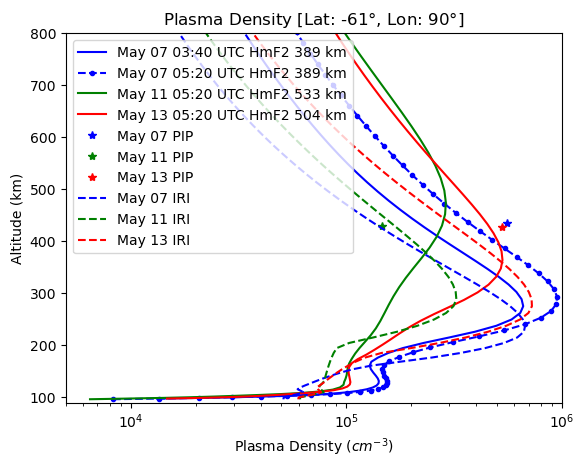

In [37]:
# Individual plot of Plasma Density 
# Including IRI

plt.plot(tieh1['N_e'][w1],tieh1['H'][w1], 'b',label='May 07 03:40 UTC HmF2 '+str(tieh1['HMF2'][1000])[0:3]+' km')
plt.plot(tieh6['N_e'][w6],tieh6['H'][w6], '.--b',label='May 07 05:20 UTC HmF2 '+str(tieh1['HMF2'][1000])[0:3]+' km')
plt.plot(tieh2['N_e'][w2],tieh2['H'][w2], 'g',label='May 11 05:20 UTC HmF2 '+str(tieh2['HMF2'][1000])[0:3]+' km')
plt.plot(tieh3['N_e'][w3],tieh3['H'][w3],'r', label='May 13 05:20 UTC HmF2 '+str(tieh3['HMF2'][1000])[0:3]+' km')

plt.plot(may_ni[0]*1e-6,may_alt[0],'*b',label='May 07 PIP')
plt.plot(may_ni[1]*1e-6,may_alt[1],'*g',label='May 11 PIP')
plt.plot(may_ni[2]*1e-6,may_alt[2],'*r',label='May 13 PIP')

plt.plot(irimay07Ne*1e-6,tieh1['H'][w2],'--b',label='May 07 IRI')
plt.plot(irimay11Ne*1e-6,tieh1['H'][w1],'--g',label='May 11 IRI')
plt.plot(irimay13Ne*1e-6,tieh1['H'][w3],'--r',label='May 13 IRI')

plt.ylabel('Altitude (km)')
plt.xlabel('Plasma Density ($cm^{-3}$)')
plt.ylim([90,800])
plt.xlim([5e3,1e6])
plt.legend(loc='upper left')
plt.xscale('log')
plt.title('Plasma Density [Lat: -61$\degree$, Lon: 90$\degree$]')
plt.savefig(savedir+'TIEGCM\\LLITED_TIEGCM_heightelectrondensity.png',facecolor='white',transparent=0,bbox_inches='tight')



plt.show()


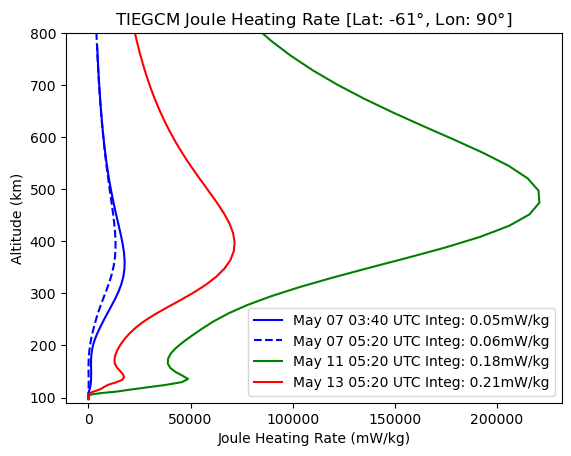

In [38]:
# Individual plot of TIE_GCM Joule Heating rate

plt.plot(tieh1['QJOULE'][w1],tieh1['H'][w1],'b', label='May 07 03:40 UTC Integ: '+str(tieh1['QJOULE_INTEG'][1000])[0:4]+'mW/kg')
plt.plot(tieh6['QJOULE'][w6],tieh6['H'][w6], '--b',label='May 07 05:20 UTC Integ: '+str(tieh6['QJOULE_INTEG'][1000])[0:4]+'mW/kg')
plt.plot(tieh2['QJOULE'][w2],tieh2['H'][w2], 'g',label='May 11 05:20 UTC Integ: '+str(tieh2['QJOULE_INTEG'][1000])[0:4]+'mW/kg')
plt.plot(tieh3['QJOULE'][w3],tieh3['H'][w3], 'r',label='May 13 05:20 UTC Integ: '+str(tieh3['QJOULE_INTEG'][1000])[0:4]+'mW/kg')

plt.ylabel('Altitude (km)')
plt.xlabel('Joule Heating Rate (mW/kg)')
plt.legend()
plt.ylim([90,800])

plt.title('TIEGCM Joule Heating Rate [Lat: -61$\degree$, Lon: 90$\degree$]')
#plt.savefig(savedir+'TIEGCM\\LLITED_TIEGCM_heightJouleheating.png',facecolor='white',transparent=0,bbox_inches='tight')
plt.show()


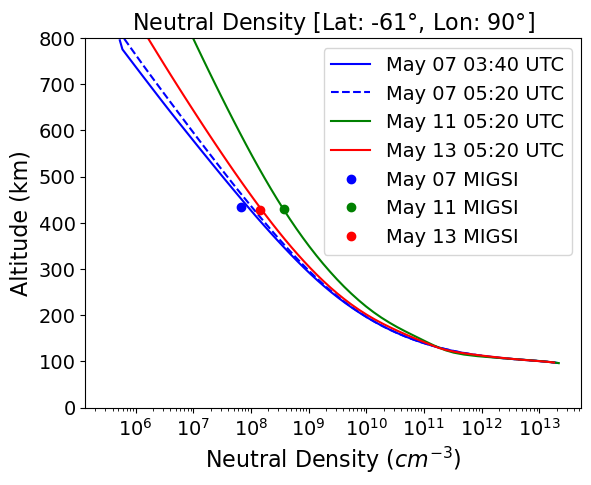

In [39]:
# Individual plot of Neutral Density 

plt.plot(tiegcm_n1,tieh1['H'][w1],'b', label='May 07 03:40 UTC')
plt.plot(tiegcm_n6,tieh6['H'][w6],'--b', label='May 07 05:20 UTC')
plt.plot(tiegcm_n2,tieh2['H'][w2],'g', label='May 11 05:20 UTC')
plt.plot(tiegcm_n3,tieh3['H'][w3],'r', label='May 13 05:20 UTC')

plt.plot(may_nden[0],may_alt[0],'ob',label='May 07 MIGSI')
plt.plot(may_nden[1],may_alt[1],'og',label='May 11 MIGSI')
plt.plot(may_nden[2],may_alt[2],'or',label='May 13 MIGSI')

plt.ylabel('Altitude (km)',fontsize=16)
plt.xlabel('Neutral Density $(cm^{-3})$',fontsize=16)
plt.ylim([0,800])
plt.legend(loc='upper right',fontsize=14)
plt.xscale('log')
plt.title('Neutral Density [Lat: -61$\degree$, Lon: 90$\degree$]',fontsize=16)
plt.savefig(savedir+'TIEGCM\\LLITED_TIEGCM_heightneutralden.png',facecolor='white',transparent=0,bbox_inches='tight')
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)
plt.show()


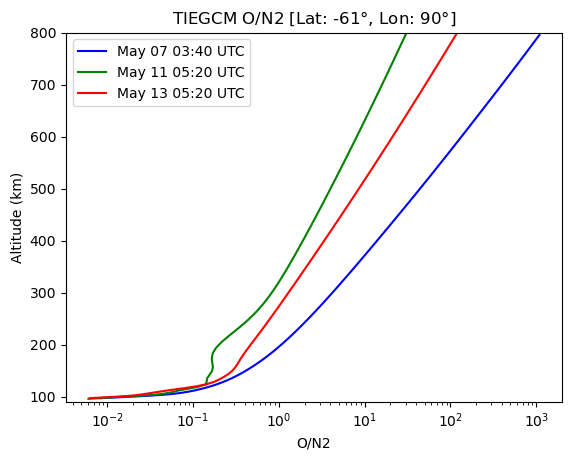

In [40]:
# Individual plot of TIE-GCM O/N2 ratio

plt.plot(tieh1['O_N2'][w1],tieh1['H'][w1],'b', label='May 07 03:40 UTC')
plt.plot(tieh2['O_N2'][w2],tieh2['H'][w2],'g', label='May 11 05:20 UTC')
plt.plot(tieh3['O_N2'][w3],tieh3['H'][w3],'r', label='May 13 05:20 UTC')

plt.ylabel('Altitude (km)')
plt.xlabel('O/N2')
plt.ylim([90,800])
plt.legend(loc='upper left')
plt.xscale('log')
plt.title('TIEGCM O/N2 [Lat: -61$\degree$, Lon: 90$\degree$]')
#plt.savefig(savedir+'TIEGCM\\LLITED_TIEGCM_heightO_N2.png',facecolor='white',transparent=0,bbox_inches='tight')

plt.show()
